# Predict house price in Warsaw using PyTorch


### Import necessary libraries

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch

### Load and analyze the dataset
Visualize what's inside the dataset. 

What type of data are we looking at.

Display charts, dependencies and check if dataset is clean.

In [184]:
df = pd.read_csv("../datasets/warsaw_houses.csv")

In [185]:
df.head()

,district,rooms,square_meters,price
0,Wola,1,29.0,2300
1,Bemowo,3,61.0,3300
2,Ursynów,3,68.0,3499
3,Śródmieście,3,172.0,40000
4,PragaPółnoc,2,40.0,2500


In [186]:
df.shape

(1038, 4)

In [187]:
df.describe()

,rooms,square_meters,price
count,1038.000000,1038.000000,1038.000000
mean,2.301541,58.238834,5999.289981
std,0.874264,32.275873,15918.373740
min,1.000000,17.290000,1700.000000
25%,2.000000,39.700000,3000.000000
50%,2.000000,49.800000,3600.000000
75%,3.000000,66.000000,5000.000000
max,6.000000,328.000000,249990.000000


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   district       1038 non-null   object 
 1   rooms          1038 non-null   int64  
 2   square_meters  1038 non-null   float64
 3   price          1038 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 32.6+ KB


### Explore data with charts

In [189]:
# Collect mean prices for houses in each city district
unique_districts = df['district'].unique()
mean_prices = []

for d in unique_districts:
    single_district = df[df['district'] == d]
    mean_price = single_district['price'].mean()
    mean_prices.append(mean_price)

# Sort from most expensive to the least expensive
districts_prices = sorted(zip(unique_districts, mean_prices), key=lambda pair: pair[1], reverse=True)
districts, prices = zip(*districts_prices)

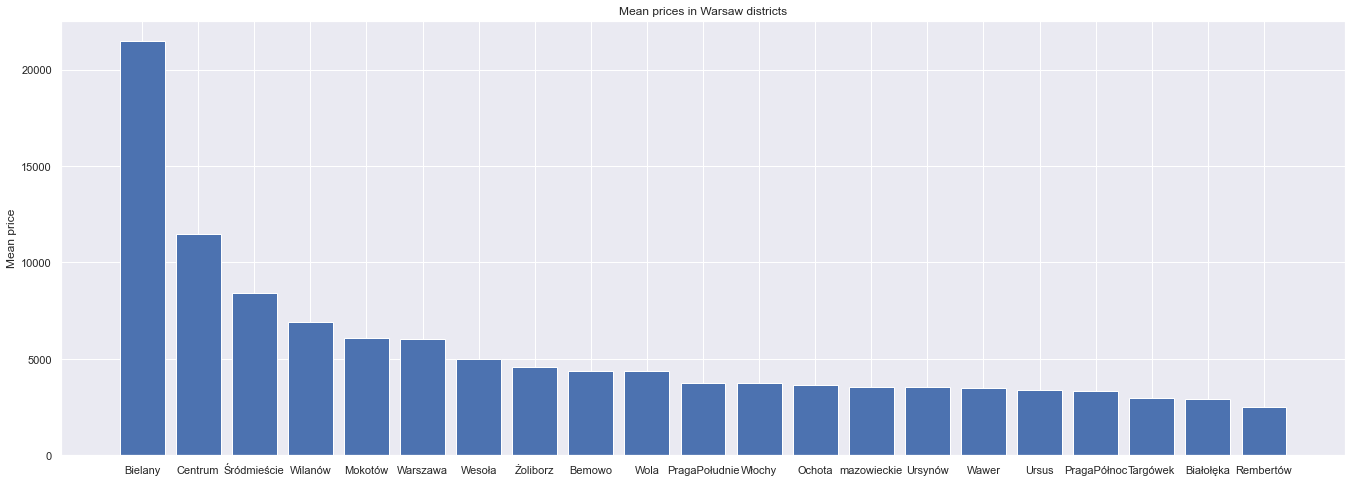

In [190]:
# Show prices in the chart
fig, ax = plt.subplots(figsize=(23,8))

ax.bar(districts, prices)

ax.set_ylabel('Mean price')
ax.set_title('Mean prices in Warsaw districts')

plt.show()

In [191]:
# Count houses number for each district
houses_count = []
for d in districts:
    single_district = df[df['district'] == d]
    houses_count.append(len(single_district))


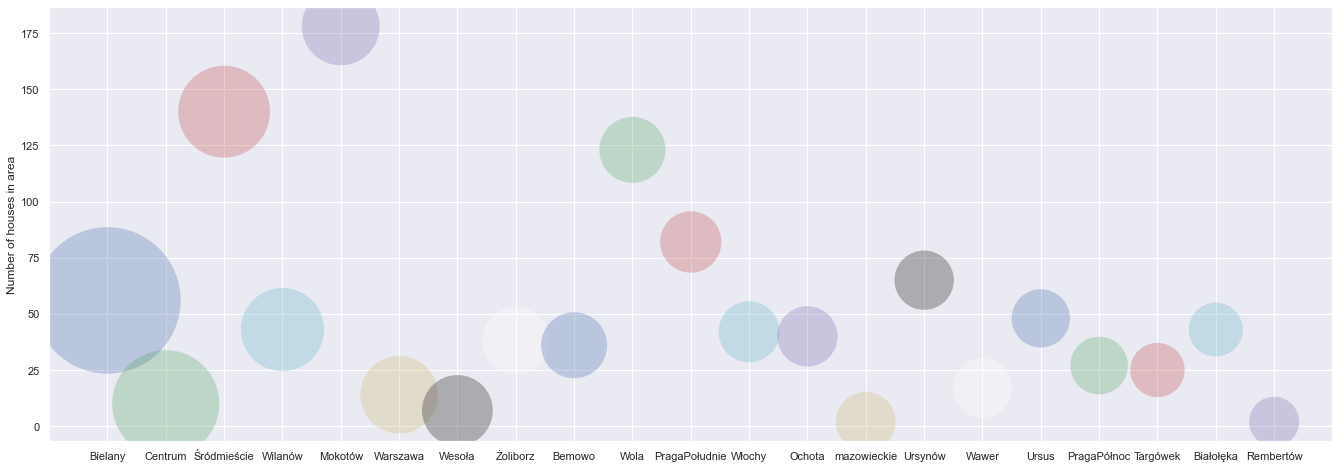

In [192]:
# Let's see a scatterplot to check how
colors = list("bgrcmykw")*3
colors = colors[:len(districts)]

fig, ax = plt.subplots(figsize=(23,8))

ax.scatter(districts, houses_count, c=colors, s=prices, alpha=0.3, edgecolors='none')
ax.set_ylabel('Number of houses in area')
ax.grid(True)

plt.show()

### Try to find outliers in the feature columns

In [193]:
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.ensemble import IsolationForest # Outlier Detection
from keras.models import Sequential # Sequential Neural Network
from keras.layers import Dense
from keras.callbacks import EarlyStopping # Early Stopping Callback
from keras.optimizers import Adam # Optimizer
import warnings

warnings.filterwarnings('ignore') # To ignore warnings.

In [194]:
df = df.drop(df[(df['rooms'] == 2)  & (df['price']>50000)].index)

Text(0.5, 0.98, '0       1\n1       3\n2       3\n3       3\n4       2\n       ..\n1033    3\n1034    3\n1035    1\n1036    3\n1037    2\nName: rooms, Length: 1034, dtype: int64 Analysis')

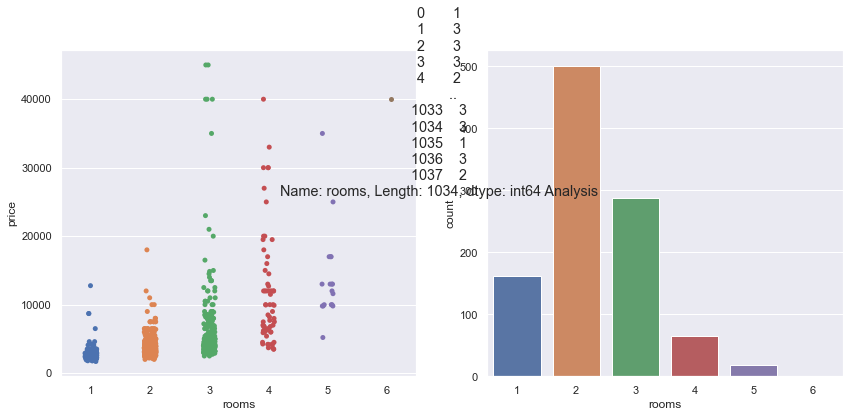

In [195]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
sns.stripplot(x='rooms', y='price', data=df, ax=ax[0])
sns.countplot(df['rooms'], ax=ax[1])
fig.suptitle(str(df['rooms']) + ' Analysis')

In [196]:
df = df.drop(df[df['square_meters'] > 100].index)
df = df.drop(df[df['price'] > 15_000].index)

Text(0.5, 0.98, 'square_meters Analysis')

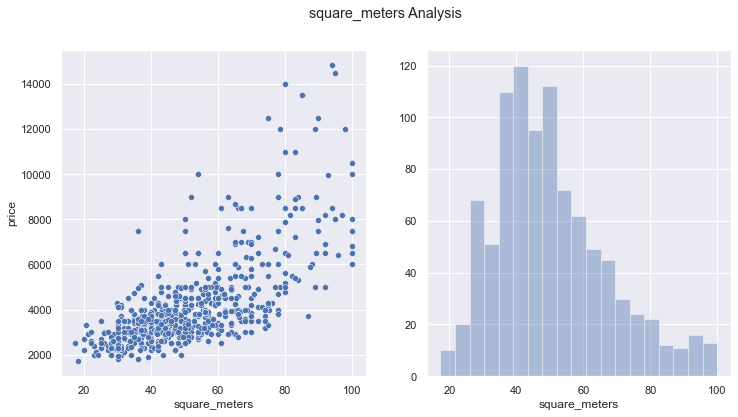

In [197]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(x='square_meters', y='price', data=df, ax=ax[0])
sns.distplot(df['square_meters'], kde=False, ax=ax[1])
fig.suptitle(str('square_meters') + ' Analysis')

### Data cleaning and preparation for model training

In [198]:
# Remove rows with 'mazowieckie' district as it is not a valid district
df = df.drop(df[df.district == "mazowieckie"].index)

# df = df.drop(['district'], axis=1)

# Use OrdinalEncoding to encode categorical values to numerical ones
enc = OrdinalEncoder()
df[['district']] = enc.fit_transform(df[['district']])

In [199]:
df.head()

,district,rooms,square_meters,price
0,16.0,1,29.0,2300
1,0.0,3,61.0,3300
2,11.0,3,68.0,3499
4,7.0,2,40.0,2500
5,1.0,2,40.0,2200


In [273]:
# Separate features from prices
house_features = df.loc[:, df.columns != "price"]
house_prices = df['price']

In [274]:
# Prepare train and test sets
X_train, x_test, Y_train, y_test = train_test_split(house_features, house_prices, test_size=0.2, random_state=42)

In [275]:
# Data standarization
scaler = StandardScaler()
# fit scaler on data
X_train_norm = scaler.fit_transform(X_train)

### Training the model - Keras

In [276]:
from keras.models import Sequential
from keras.layers import Dense

In [277]:
def shallow_network():
    # create model
    model = Sequential()
    model.add(Dense(320, activation='relu', input_shape=(len(house_features.columns),)))
    model.add(Dense(384, activation='relu'))
    model.add(Dense(352, activation='relu'))
    model.add(Dense(448, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [278]:
model = shallow_network()

In [279]:
training_history = model.fit(X_train_norm, Y_train, validation_split=0.2, epochs=120, verbose=2)

Epoch 1/120


2023-03-05 17:55:36.106357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 - 1s - loss: 19381180.0000 - val_loss: 15714789.0000 - 540ms/epoch - 28ms/step
Epoch 2/120
19/19 - 0s - loss: 7118436.5000 - val_loss: 4084149.7500 - 127ms/epoch - 7ms/step
Epoch 3/120


2023-03-05 17:55:36.403694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 - 0s - loss: 3206240.7500 - val_loss: 2445972.2500 - 125ms/epoch - 7ms/step
Epoch 4/120
19/19 - 0s - loss: 2416416.0000 - val_loss: 2164932.5000 - 133ms/epoch - 7ms/step
Epoch 5/120
19/19 - 0s - loss: 2223119.2500 - val_loss: 1870320.3750 - 128ms/epoch - 7ms/step
Epoch 6/120
19/19 - 0s - loss: 1986928.8750 - val_loss: 1739346.1250 - 125ms/epoch - 7ms/step
Epoch 7/120
19/19 - 0s - loss: 1955176.7500 - val_loss: 1657955.3750 - 128ms/epoch - 7ms/step
Epoch 8/120
19/19 - 0s - loss: 1801044.1250 - val_loss: 1707249.2500 - 123ms/epoch - 6ms/step
Epoch 9/120
19/19 - 0s - loss: 1728120.8750 - val_loss: 1529597.8750 - 122ms/epoch - 6ms/step
Epoch 10/120
19/19 - 0s - loss: 1757414.3750 - val_loss: 1492861.5000 - 125ms/epoch - 7ms/step
Epoch 11/120
19/19 - 0s - loss: 1678416.6250 - val_loss: 1430787.0000 - 130ms/epoch - 7ms/step
Epoch 12/120
19/19 - 0s - loss: 1706146.2500 - val_loss: 1452648.6250 - 128ms/epoch - 7ms/step
Epoch 13/120
19/19 - 0s - loss: 1748509.1250 - val_loss: 1490853.3750

Epoch 90/120
19/19 - 0s - loss: 1354542.3750 - val_loss: 1295163.7500 - 128ms/epoch - 7ms/step
Epoch 91/120
19/19 - 0s - loss: 1337567.3750 - val_loss: 1223512.0000 - 123ms/epoch - 6ms/step
Epoch 92/120
19/19 - 0s - loss: 1410820.5000 - val_loss: 1161584.1250 - 130ms/epoch - 7ms/step
Epoch 93/120
19/19 - 0s - loss: 1316411.1250 - val_loss: 1221344.8750 - 122ms/epoch - 6ms/step
Epoch 94/120
19/19 - 0s - loss: 1336653.6250 - val_loss: 1191371.8750 - 124ms/epoch - 7ms/step
Epoch 95/120
19/19 - 0s - loss: 1374974.3750 - val_loss: 1164358.3750 - 121ms/epoch - 6ms/step
Epoch 96/120
19/19 - 0s - loss: 1325779.6250 - val_loss: 1203134.3750 - 135ms/epoch - 7ms/step
Epoch 97/120
19/19 - 0s - loss: 1314811.1250 - val_loss: 1196634.8750 - 127ms/epoch - 7ms/step
Epoch 98/120
19/19 - 0s - loss: 1481368.3750 - val_loss: 1488310.5000 - 127ms/epoch - 7ms/step
Epoch 99/120
19/19 - 0s - loss: 1492070.3750 - val_loss: 1352458.1250 - 127ms/epoch - 7ms/step
Epoch 100/120
19/19 - 0s - loss: 1398373.8750 - va

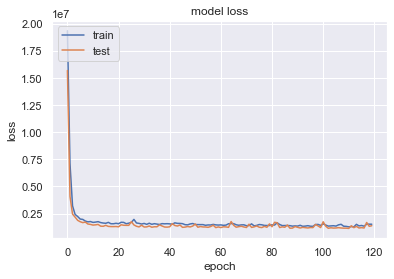

In [280]:
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [183]:
X_train.head()

,district,rooms,square_meters
90,4.0,1,32.0
1029,6.0,2,45.0
801,19.0,2,31.0
1024,11.0,3,55.0
961,18.0,1,39.0


### Training the model - Torch


In [260]:
dtype = torch.float
X_train_tensor = torch.tensor(X_train_norm, dtype=dtype)
x_test_tensor = torch.tensor(x_test.values, dtype=dtype)

Y_train_tensor = torch.tensor(Y_train.values, dtype=dtype)
y_test_tensor = torch.tensor(y_test.values, dtype=dtype)

X_train_tensor.shape

torch.Size([752, 3])

In [261]:
input_features_amount = 3
output_amount = 1
hidden_layer_size = 300


loss_function = torch.nn.MSELoss()
learning_rate = 1e-3

In [262]:
model = torch.nn.Sequential(torch.nn.Linear(input_features_amount, hidden_layer_size),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(hidden_layer_size, output_amount))

In [263]:
loss_list = []
EPOCHS = 200_000
Y_train_tensor = torch.reshape(Y_train_tensor, (X_train_tensor.shape[0], 1))

for epoch in range(EPOCHS):
    y_pred = model(X_train_tensor)
    loss = loss_function(y_pred, Y_train_tensor)
    
    if epoch % 1000 == 0:
        print(epoch, loss.item())
    
    loss_list.append(loss.item())
    model.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

0 19667308.0
1000 1201414.0
2000 1147755.375
3000 1107842.75
4000 1071822.875
5000 1040591.5
6000 1016015.25
7000 991627.375
8000 965078.8125
9000 941406.4375
10000 920537.25
11000 898527.9375
12000 880101.4375
13000 864849.1875
14000 846944.4375
15000 829419.25
16000 814757.25
17000 801360.625
18000 790049.8125
19000 775480.6875
20000 760388.625
21000 747782.125
22000 736129.625
23000 725584.875
24000 715280.625
25000 704351.375
26000 694392.125
27000 685689.1875
28000 676668.125
29000 667236.0625
30000 658226.4375
31000 649053.6875
32000 640679.6875
33000 633451.4375
34000 626605.5
35000 620488.875
36000 615089.0625
37000 609736.625
38000 604403.0
39000 599990.125
40000 595341.875
41000 591100.1875
42000 586499.0
43000 582600.375
44000 579395.3125
45000 576405.75
46000 570621.25
47000 568666.75
48000 563882.1875
49000 560184.9375
50000 556893.375
51000 554019.8125
52000 550871.375
53000 549119.6875
54000 544418.4375
55000 542461.75
56000 541037.1875
57000 537903.8125
58000 535905.25


In [458]:
# !!! Error that occured before
# .../loss.py:530: UserWarning: Using a target size (torch.Size([828])) that is different to the input size (torch.Size([828, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
#  return F.mse_loss(input, target, reduction=self.reduction)

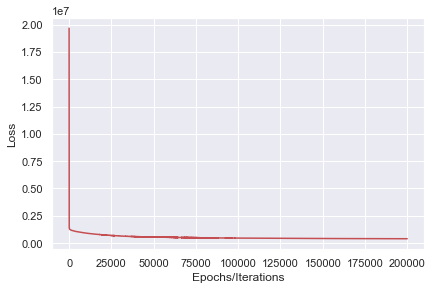

In [264]:
# Plotting the loss after each iteration
plt.plot(loss_list, 'r')
plt.tight_layout()
plt.grid('True')
plt.xlabel("Epochs/Iterations")
plt.ylabel("Loss")
plt.show()

In [271]:
index = 10
sample = x_test.iloc[index]
actual = y_test.iloc[index]

sample_tensor = torch.tensor(sample.values, dtype=dtype)
sample_tensor

tensor([ 4.0000,  2.0000, 55.6000])

In [272]:
# Make predictions on the test set sample and see how it performs

predicted = model(sample_tensor)
print(f"Predicted: {predicted.item()}")
print(f"Actual: {actual}")
print(f"Difference {int(predicted.item() - actual)}")

Predicted: 10295.044921875
Actual: 4700
Difference 5595
